<a href="https://colab.research.google.com/github/GerardoFesta/3DFER_SE4AI/blob/main/models/3DModels/VoxelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install -q mlflow
!databricks configure --host https://community.cloud.databricks.com/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00
Username: gfesta24@gmail.com
Password: 
Repeat for confirmation: 


In [3]:
import sys
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import numpy as np
from sklearn.model_selection import ParameterGrid

In [4]:
train_df = np.load('/content/drive/Shareddrives/Datasets SEFAI/voxel_train_dataset.npz')
test_df = np.load('/content/drive/Shareddrives/Datasets SEFAI/voxel_test_dataset.npz')

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X_array, Y_array, transform=None):
        self.X = X_array
        self.Y = Y_array
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        label = self.Y[index]

        # Esegui le trasformazioni se definite
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [6]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/gfesta24@gmail.com/Voxels3DCNN")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/2211619870750348', creation_time=1686564463983, experiment_id='2211619870750348', last_update_time=1687958042418, lifecycle_stage='active', name='/Users/gfesta24@gmail.com/Voxels3DCNN', tags={'mlflow.experiment.sourceName': '/Users/gfesta24@gmail.com/Voxels3DCNN',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'gfesta24@gmail.com',
 'mlflow.ownerId': '1923923806180228'}>

In [7]:
X_train= train_df['data']
X_test = test_df['data']
y_train = train_df['labels']
y_test = test_df['labels']


In [8]:


train_dataset = CustomDataset(X_train, y_train, transform=transforms.ToTensor())

test_dataset = CustomDataset(X_test, y_test, transform=transforms.ToTensor())

batch_size=64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
def accuracy(preds, labels):
  probabilities = torch.nn.functional.softmax(preds, dim=1)
  _, predicted = torch.max(probabilities, dim=1)
  n_correct = (predicted==labels).sum().float()

  acc =n_correct / labels.shape[0]
  acc= torch.round(acc*100)
  return acc, n_correct;

In [10]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 3), stride=1, padding=(2, 2, 1))
        self.batchnorm1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=1, padding=0)
        self.batchnorm3 = nn.BatchNorm3d(128)

        self.maxpool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3456, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.batchnorm2(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.batchnorm3(x)
        #x = self.maxpool(x)

        # Calcolo dinamico della dimensione dell'input per fc1
        batch_size = x.size(0)
        #print(x.shape)
        x = self.flatten(x)  # Flatten
        #print(x.shape)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        return x


In [ ]:
mlflow.end_run()

In [ ]:
param_grid = {'batch_size': [64, 128, 256, 512],'lr': [0.01, 0.001], "momentum":[0.7, 0.8, 0.9], "decay":[0.001, 0.01, 0.1]}
expanded_grid = ParameterGrid(param_grid)
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("/Users/gfesta24@gmail.com/Voxels3DCNN")


for i in range(len(expanded_grid)):

  runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], filter_string=" and ".join([f"params.{k} = '{v}'" for k, v in expanded_grid[i].items()] + ["tags.model_name = 'VoxelCNN3layer'"]))

  train_loader = DataLoader(train_dataset, batch_size=expanded_grid[i]['batch_size'], shuffle=True)

  test_loader = DataLoader(test_dataset, batch_size=expanded_grid[i]['batch_size'], shuffle=False)

  if len(runs) == 0:


    best_loss=100
    best_model_train_acc=0
    best_model_test_acc=0
    best_model_test_loss=0
    best_model_train_loss=0
    min_delta=0
    patience=3
    model = MyModel(num_classes = 7)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=expanded_grid[i]['lr'], momentum =expanded_grid[i]['momentum'])


    mlflow.start_run()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    num_epochs = 100
    acc_list_train=[]
    acc_list_test=[]
    model.train()

    mlflow.set_tag("model_name", "VoxelCNN3layer")
    mlflow.log_param("lr", expanded_grid[i]['lr'])
    mlflow.log_param("momentum", expanded_grid[i]['momentum'])
    mlflow.log_param("batch_size", expanded_grid[i]['batch_size'])
    mlflow.log_param("decay", expanded_grid[i]['decay'])
    best_loss = 100
    counter=0
    stop=False
    for epoch in range(num_epochs):
        if stop:
          break

        running_loss = 0.0
        running_acc = 0.0
        tot_seen = 0
        for X_batch, y_batch in train_loader:
            X_batch = torch.reshape(X_batch, (X_batch.shape[0], 1, 24, 24, 24))
            X_batch = X_batch.type(torch.cuda.FloatTensor)
            #manda i batch al device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #azzera gradiente
            optimizer.zero_grad()
            #predict
            y_pred = model(X_batch)


            #print(y_batch.shape)
            loss = criterion(y_pred, y_batch)
            _,acc = accuracy(y_pred, y_batch)
            #backpropagation della loss
            loss.backward()
            #ottimizzazione
            optimizer.step()

            #somma della loss e dell'accuracy per il batch
            running_loss += loss.item()
            running_acc += acc
            tot_seen += len(y_batch)


        print(f'Epoch {epoch}: | Loss: {running_loss/len(train_loader):.5f} | Acc: {running_acc/tot_seen:.3f}')
        acc_list_train.append(running_acc/len(train_loader))
        mlflow.log_metric("train_loss", running_loss / len(train_loader), step=epoch)
        mlflow.log_metric("train_acc", running_acc/tot_seen, step=epoch)
        tot_corrette = 0
        tot_eseguite = 0
        running_test_loss = 0
        val_loss = 0

        with torch.no_grad():

          for images, labels in test_loader:
              images = torch.reshape(images, (images.shape[0], 1, 24, 24, 24))
              images = images.type(torch.cuda.FloatTensor)
              images = images.to(device)
              labels = labels.to(device)

              outputs = model(images)
              test_loss = criterion(outputs, labels)
              _, n_corrette=accuracy(outputs, labels)

              running_test_loss += test_loss.item()
              tot_corrette+=n_corrette.item()
              tot_eseguite+=labels.shape[0]

          test_acc=100* (tot_corrette/tot_eseguite)
          val_loss = running_test_loss / len(test_loader)
          acc_list_test.append(test_acc)
          print("Test acc: ", test_acc)
          print("Test loss: ", val_loss)

          mlflow.log_metric("test_acc", test_acc, step=epoch)
          mlflow.log_metric("test_loss", val_loss, step=epoch)


        if val_loss < best_loss - min_delta:
          print("MIGLIORATO")
          best_loss = val_loss
          best_model_train_acc=running_acc/tot_seen
          best_model_test_acc=test_acc
          best_model_test_loss=val_loss
          best_model_train_loss=running_loss / len(train_loader)
          counter = 0
          # Salva i pesi del modello se la validation loss è migliorata
          torch.save(model.state_dict(), 'best_model.pt')
        else:
          counter += 1
        # Verifica se raggiunto il criterio di early stopping
          if counter >= patience:
              print(f'Early stopping at epoch {epoch+1}')
              stop=True
        print("BEST TEST LOSS: ", best_loss)

    mlflow.set_tag("Epochs_stopped", epoch+1)
    mlflow.log_artifact("best_model.pt")
    mlflow.log_metric("best_test_acc", best_model_test_acc)
    mlflow.log_metric("best_test_loss", best_model_test_loss)
    mlflow.log_metric("best_train_acc", best_model_train_acc)
    mlflow.log_metric("best_train_loss", best_model_train_loss)
    mlflow.end_run()

    print('Finished Training')

    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)
    torch.cuda.empty_cache()
  else:
    print("RUN: ", [f"params.{k} = '{v}'" for k, v in expanded_grid[i].items()], " già completata" )



In [11]:
def get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_id]).sort_values(f"{metric_name}")
    lowest_metric_run = runs.iloc[0]

    run_id = lowest_metric_run.run_id
    artifact_uri = mlflow.get_artifact_uri(run_id)

    artifact_path = f"{artifact_uri}/{artifact_name}"
    return run_id, artifact_path

# Specifica l'ID del tuo esperimento e i nomi delle metrica e dell'artefatto
experiment_id = '2211619870750348'
metric_name = 'metrics.best_test_loss'
artifact_name = 'model_weights'

run_id, artifact_path = get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name)

print("Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:")
print(artifact_path)

Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:
dbfs:/databricks/mlflow-tracking/2211619870750348/a8b5fc92fae1465cb3240dd425f16fab/artifacts/dcad6a2ca57b4f6dafec5461a7584f2f/model_weights


In [12]:
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path="/content/artefatto")

'/content/artefatto/'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Test Metrics:
Accuracy: 0.43171608265947886
Precision: [0.30198915 0.32798574 0.31806992 0.4593453  0.         0.2780083
 0.67264574]
F1 Score: [0.23755334 0.33019291 0.40174129 0.50347222 0.         0.11336717
 0.68610635]
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.20      0.24       853
           1       0.33      0.33      0.33      1107
           2       0.32      0.55      0.40      1185
           3       0.46      0.56      0.50       781
           4       0.00      0.00      0.00        97
           5       0.28      0.07      0.11       941
           6       0.67      0.70      0.69      1714

    accuracy                           0.43      6678
   macro avg       0.34      0.34      0.32      6678
weighted avg       0.41      0.43      0.41      6678



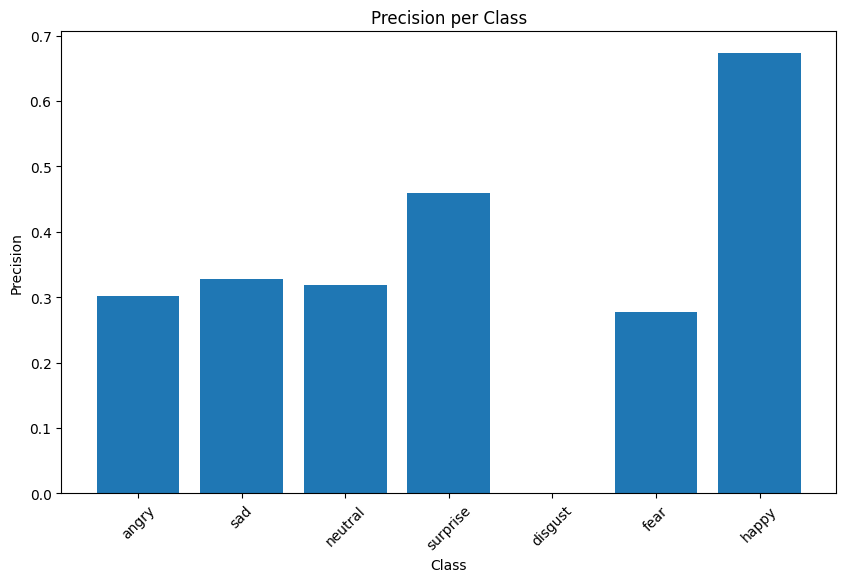

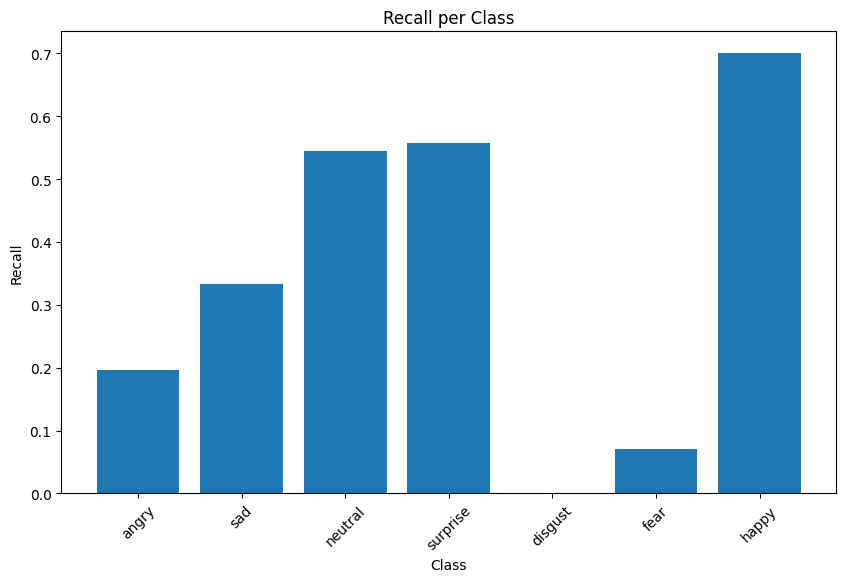

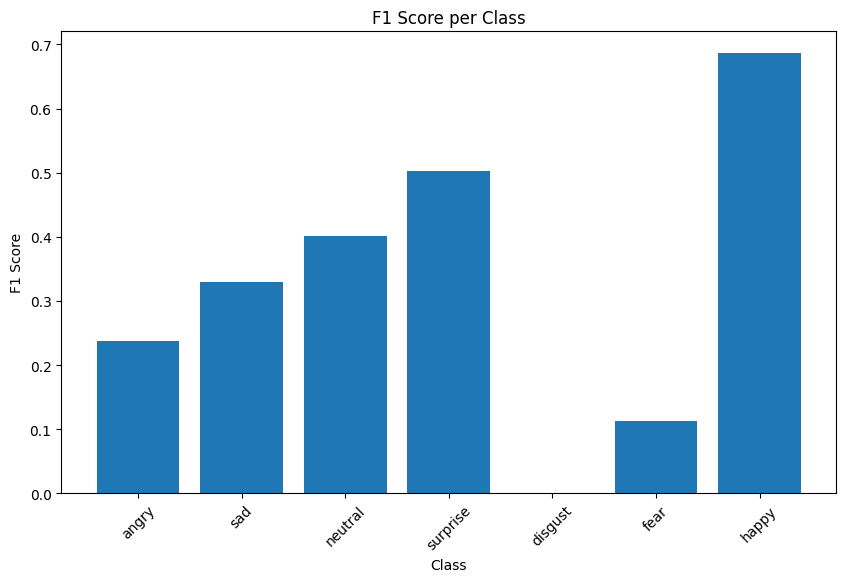

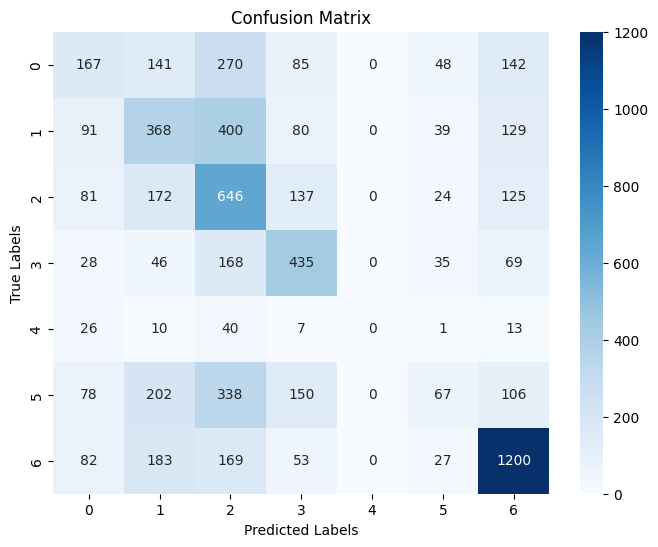

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = MyModel(7)
model.load_state_dict(torch.load("/content/artefatto/best_model.pt"))
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)



# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        images = torch.reshape(images, (images.shape[0], 1, 24, 24, 24))
        images = images.type(torch.cuda.FloatTensor)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)
label_dict = {"angry":0, "sad": 1, "neutral": 2, "surprise": 3, "disgust": 4, "fear": 5, "happy": 6}

# Lista delle etichette delle classi
#class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
class_labels=[9,9,9,9,9,9,9]
for label in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
  class_labels[label_dict[label]]=label




# Crea il grafico a barre per la precisione
plt.figure(figsize=(10, 6))
plt.bar(class_labels, precision)
plt.title('Precision per Class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per il recall
plt.figure(figsize=(10, 6))
plt.bar(class_labels, recall)
plt.title('Recall per Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per l'F1-score
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1)
plt.title('F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()


# Calcola la matrice di confusione
cm = confusion_matrix(test_labels, test_predictions)

# Crea una figura e un'asse per la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Imposta i nomi delle etichette sulle assi x e y
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Visualizza la matrice di confusione
plt.show()